# l-1 trend filtering (18 pts)

В своей знаменитой статье [l-1 trend filtering](https://web.stanford.edu/~boyd/papers/l1_trend_filter.html) Стивен Бойд и его коллеги предложили подход к выявлению тренда в финансовых временных рядах с помощью выпуклой оптимизации. В частности, вместо построения стохастической модели временного ряда, они предложили отталкиваться от задачи - построить кусочно-линейную линию тренда, наилучшим образом аппроксимирующую данный временной ряд.

Это привело к задачи оптимизации следующего вида:

**TrendFilter problem**
$$
\min_{x \in R^T} \frac{1}{2}\|y - x\|_2^2 + \lambda \|Dx\|_1
$$
где $y \in R^T$ - временной ряд фактических цен акции (с момента времени $t = 1$ до момента времени $T$), матрица $D \in R^{(T-2) \times T}$ является трехдиагональной: $[Dx]_i = x_i - 2 \cdot x_{i+1} + x_{i+2} \quad$ ($1\leq i \leq T-2$).

Первый член в целевой функции отвечает за близость решения к фактическим данным, а второй форсирует решение  быть кусочно-линейной функцией с минимальным числом "изломов". 

Задание:
1. (1 pts.) Скачайте тестовые данные: данные о цене закрытия акций российских финансовых компаний (например, с finam.ru). Это ваши тестовые данные. 
2. (3 pts.) Выпишите двойственную задачу для задачи Trend Filter.
3. (3 pts.) Численно решите задачу Trend Filter используя одну из версий проксимального градиентного спуска.
4. (5 pts.) Выпишите сглаженную версию задачи Trend Filter и найдите ее решение используя метод быстрого градиентного спуска (версия из лекции про сглаживание).
5. (4 pts.) Выпишите схему ADMM для решения задачи Trend Filter, реализуйте ее и найдите численное решение задачи. 
6. (2 pts.) Сравните полученные результаты на тестовых данных.

## Задание 1

           TICKER PER      TIME   CLOSE
DATE                                   
2020-01-03   GAZP   D  00:00:00  259.00
2020-01-06   GAZP   D  00:00:00  256.55
2020-01-08   GAZP   D  00:00:00  255.79
2020-01-09   GAZP   D  00:00:00  254.07
2020-01-10   GAZP   D  00:00:00  251.90


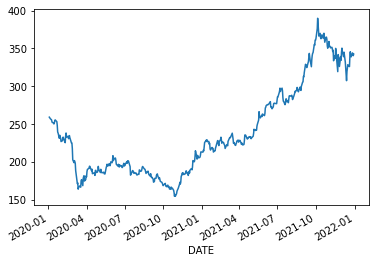

In [452]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

TestDataFile = pd.read_csv('GAZP_200101_220101.csv', sep = ';', index_col = 'DATE', parse_dates = True,
                           names = ['TICKER', 'PER', 'DATE', 'TIME', 'CLOSE'])
print(TestDataFile.head())

TestDataPlot = TestDataFile['CLOSE']
TestDataPlot.plot()
plt.show()

## Задание 2

### Выпишем двойственную задачу для задачи Trend Filter

Для того, чтобы получить двойственную задачу для исходной, необходимо первоначально ввести новую переменную $z \in \mathbb{R}^{n - 2}$ и новое ограничение вида $z = Dx$, чтобы получить эквивалентную формулировку:
$$
minimize~~~\frac{1}{2}||y - x||^2_2 + \lambda||z||_1\\
subject~to~~~z = Dx
$$
Выпишем лагранжиан:
$$
L(x, z, \nu) = \frac{1}{2}||y - x||^2_2 + \lambda||z||_1 + \nu(Dx - z),~~~\nu \in \mathbb{R}^{n - 2}
$$
Выпишем двойственную функцию:
\begin{equation*}
\underset{x, z}{\inf}L = 
    \begin{cases}
        -\frac{1}{2}\nu^TDD^T\nu + y^TD^T\nu,~~~ -\lambda\vec{1} \leqslant \nu \leqslant \lambda\vec{1},\\
        -\infty,~~~ otherwise
    \end{cases}
\end{equation*}


Таким образом, получаем двойственную задачу:
$$
\underset{\nu}{minimize}~~~-\frac{1}{2}\nu^TDD^T\nu + y^TD^T\nu\\
subject~to~~~-\lambda\vec{1} \leqslant \nu \leqslant \lambda\vec{1}
$$

## Задание 3

In [338]:
# Cделаем линейную замену и решим задачу l-1 регуляризации, а затем сделаем обратную замену
# Используем проксимальный градиентный метод с подбором длины шага по схеме Нестерова

def func(x, A, b):
    return 0.5 * np.linalg.norm(A.dot(x) - b)**2 

def grad(A, b, y): # градиент функции (1/2)*||Ab - y||_2^2
    return A.T @ (A @ b - y)

def ProxFunc(bNext, alpha):
    for i in range(2, len(bNext)):
        if bNext[i] < -alpha:
            bNext[i] += alpha
        elif bNext[i] > alpha:
            bNext[i] -= alpha
        else:
            bNext[i] = 0
    return bNext

def L1TrendFilteringSolveProx(Lambda = 0, MaxIter = 500):
    DefaultStepSize = 1e-10
    StepSize = DefaultStepSize
    fk_old = np.inf
    y = TestDataFile['CLOSE'].to_numpy()
    NormalizationTerm = y[0]
    y -= NormalizationTerm
    T = y.size
    x_k = np.zeros(T)
    A = np.zeros((T, T))
    for i in range(T):
        for j in range(i, T):
            if i == 0:
                A[j][i] = 1
            else:
                A[j][i] = j + 1 - i
    
    fk, grad_fk = func(x_k, A, y), grad(A, x_k, y)
    
    for _ in tqdm(range(MaxIter)):
        while True:
            x_k_new = ProxFunc(x_k - StepSize * grad_fk, Lambda * StepSize)
            m_func = fk + grad_fk.T.dot(x_k_new - x_k) + 1 / (2 * StepSize) * (x_k_new - x_k).dot(x_k_new - x_k)
            if func(x_k_new, A, y) <= m_func:
                break
            else:
                StepSize *= 0.5
        
        x_k = x_k_new
        fk_old = fk
        fk, grad_fk = func(x_k, A, y), grad(A, x_k, y)
        StepSize = max(DefaultStepSize, StepSize * 2)
        
    y_prox = A @ x_k
    y += NormalizationTerm
    y_prox += NormalizationTerm
    plt.figure(figsize = (15, 5))
    plt.plot(y_prox)
    plt.plot(y)

### Тесты

100%|██████████| 1000000/1000000 [15:34<00:00, 1069.56it/s]


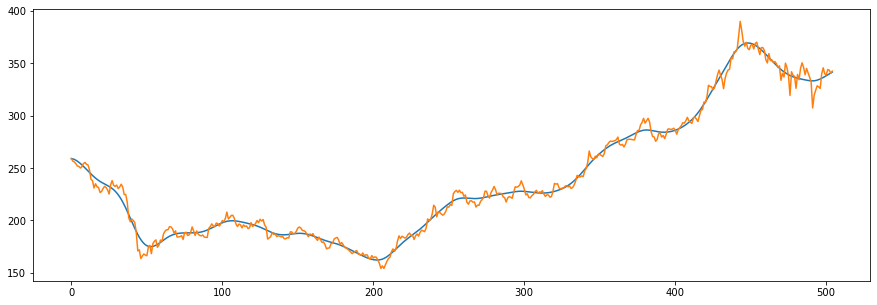

In [339]:
L1TrendFilteringSolveProx(MaxIter = 1000000, Lambda = 0)

100%|██████████| 1000000/1000000 [12:48<00:00, 1301.36it/s]


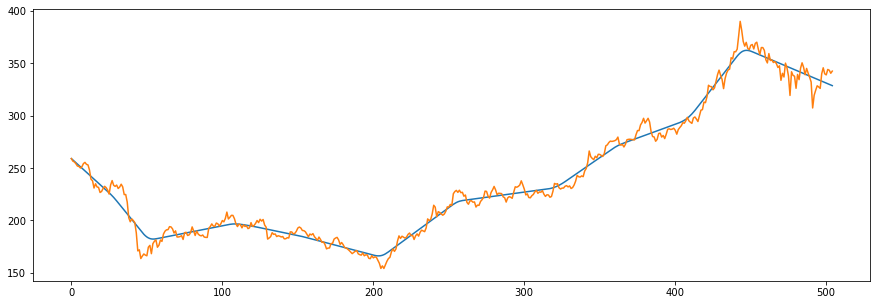

In [341]:
L1TrendFilteringSolveProx(MaxIter = 1000000, Lambda = 1000)

100%|██████████| 1000000/1000000 [13:59<00:00, 1191.49it/s]


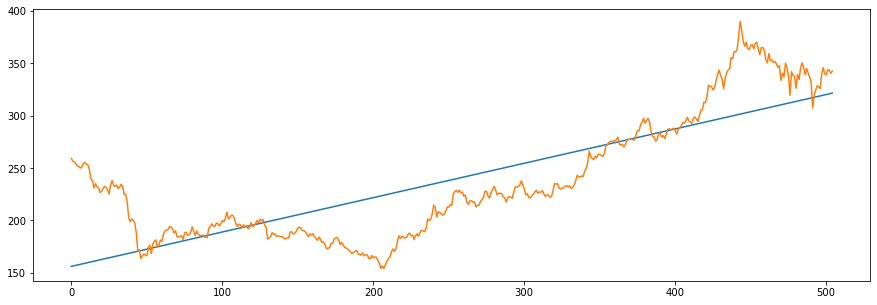

In [343]:
L1TrendFilteringSolveProx(MaxIter = 1000000, Lambda = 1000000)

## Задание 4

#### Первоначально рассмотрим следующую технику сглаживания:
- Рассмотрим задачу 
$$
f(x) \rightarrow \underset{x \in Q_1}{min}, \text{где}~f - \text{выпуклая функция, а}~Q_1~- \text{выпуклое множество}
$$
- При этом считаем, что у функции $f$ некоторая специальная структура:
$$
f(x) = \underset{u \in Q_2}{max}\{u^TAx + \varphi_2(u)\} + \varphi_1(x), 
$$
где функция $\varphi_1(x)$ - гладкая, выпуклая, с липшицевым градиентом, а $\underset{u \in Q_2}{max}\{u^TAx + \varphi_2(u)\}$, в общем случае, не обязан быть гладким.
- Рассмотрим функцию $d_2(u)$, которая является проксимальной функцией по $u$, то есть она сильно выпукла с константой выпуклости $\sigma_2$ и равна нулю в точке $u^* = argmin(d_2(u)), u^* \in Q_2$.
- Далее будем смотреть на функцию
$$
f_{\mu}(x) = \underset{u \in Q_2}{max}\{u^TAx + \varphi_2(u) - \mu d_2(u)\} + \varphi_1(x)
$$
- Имеем следующие неравенства:
$$
f_{\mu}(x) \geqslant f(x) \geqslant f_{\mu}(x) + \mu D_2
$$

- Данная функция является гладкой, и это нетрудно понять, рассмотрев градиент данной функции:

$$
\nabla{f_{\mu}(x)} = \nabla{\varphi_1(x)} + \nabla{\{\{u^*(x)\}^TAx + \varphi_2(u^*(x)) - \mu d_2(u^*(x))\}} = \nabla{\varphi_1(x)} + A^Tu^*(x)
$$

##### Теперь выпишем сглаженную версию нашей задачи:
$$
Ax = \lambda Dx,~~~Q_2 = \{u: |u_i| \geqslant 1\},~~~\varphi_2(x) = 0,~~~\varphi_1(x) = \frac{1}{2}||x - y||_2^2
$$
$$
\{f(x) = \underset{u \in \{u: |u_i| \geqslant 1\}}{max}\{\lambda u^TDx\} + \frac{1}{2}||x - y||_2^2\} \rightarrow \underset{x \in Q_1}{min}
$$

- Возьмем в качестве функции $d_2(u) = ||u||_2^2$. Окончательно получаем

$$
f_{\mu}(x) = \underset{u \in \{u: |u_i| \leqslant 1\}}{max}\{\lambda u^TDx - \mu ||u||_2^2\} + \frac{1}{2}||x - y||_2^2\}
$$

$$
\nabla{f_{\mu}(x)} = x - y + \lambda D^Tu^*(x)
$$

- Найдем $u^*(x)$:

    - Рассмотрим функцию, которую нам надо максимизировать:
    $$
    g(x) = \lambda u^TDx - \mu ||u||_2^2 = \sum_{i = 1}^{T - 2}{\{u_i \lambda \{Dx\}_i - \mu u_i^2\}}
    $$
    
    - Следовательно, 
    \begin{equation*}
    u^*_i =
    \begin{cases}
        \frac{(Dx)_i}{2\mu},~~ |\lambda(Dx)_i| < 2\mu,\\
        1,~~ \lambda (Dx)_i > 2\mu,\\
        -1,~~ \lambda (Dx)_i < -2\mu
    \end{cases}
    \end{equation*}

In [1104]:
import math

def f(y_k, D, m, data, Lambda, T):
    u = u_compute(D, y_k, m, T, Lambda)
    return Lambda * u @ (D @ y_k) - m * np.linalg.norm(u)**2 + (1 / 2) * np.linalg.norm(y_k - data)**2

def u_compute(D, x_k, m, T, Lambda):
    z = Lambda * D @ x_k
    s = np.zeros(T - 2)
    for i in range(T - 2):
        if z[i] > 2 * m:
            s[i] = 1
        elif z[i] < 2 * m:
            s[i] = -1
        else:
            s[i] = z[i] / (2 * m)
    return s

def grad(x_k, data, D, Lambda, T, m):
    u = u_compute(D, x_k, m, T, Lambda)
    return x_k - data + Lambda * D.T @ u

def FGD_Nesterov(alpha = 1, r = 0.5, Theta = 1.1, MaxIter = 10000, m = 1e4, Lambda = 0):
    data = TestDataFile['CLOSE'].to_numpy()
    T = y.size
    D = np.zeros((T - 2, T))
    for i in range(T - 2):
        D[i][i] = 1
        D[i][i + 1] = -2
        D[i][i + 2] = 1
    x_k = np.zeros(T)
    v_k = np.zeros(T)
    A_k = 0
    for _ in tqdm(range(MaxIter)):
        while True:
            alpha_next = alpha + math.sqrt(alpha * (alpha + 2 * A_k))
            y_k = (A_k * x_k + alpha_next * v_k) / (A_k + alpha_next)
            f_yk = f(y_k, D, m, data, Lambda, T)
            grad_f_yk = grad(y_k, data, D, Lambda, T, m)
            x_k_next = y_k - alpha * grad_f_yk
            grad_f_xk_next = grad(x_k_next, data, D, Lambda, T, m)
            if grad_f_xk_next @ (y_k - x_k_next) >= alpha * np.linalg.norm(grad_f_xk_next)**2:
                break
            alpha = r * alpha
        v_k = v_k - alpha_next * grad_f_xk_next
        A_k = A_k + alpha_next
        alpha = Theta * alpha
        x_k = x_k_next
    plt.figure(figsize = (15, 5))
    plt.plot(x_k)
    plt.plot(data)

100%|██████████| 10/10 [00:00<00:00, 122.80it/s]


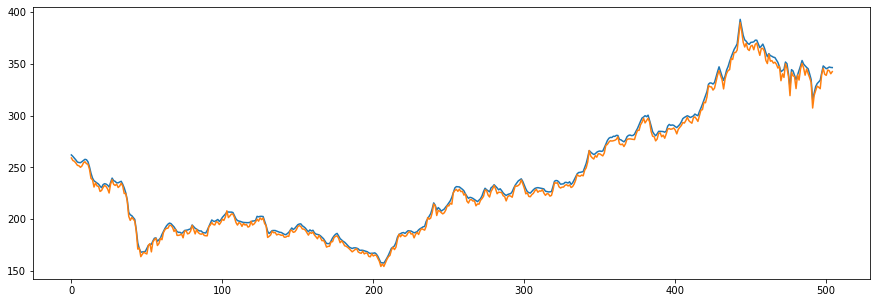

In [1105]:
FGD_Nesterov(alpha = 1, r = 0.5, Theta = 1.1, MaxIter = 10, m = 1e-5, Lambda = 1)

In [1107]:
D = np.zeros((T - 2, T))
for i in range(T - 2):
    D[i][i] = 1
    D[i][i + 1] = -2
    D[i][i + 2] = 1
        
print(D)

[[ 1. -2.  1. ...  0.  0.  0.]
 [ 0.  1. -2. ...  0.  0.  0.]
 [ 0.  0.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  1.  0.  0.]
 [ 0.  0.  0. ... -2.  1.  0.]
 [ 0.  0.  0. ...  1. -2.  1.]]


## Задание 5

#### Выпишем схему ADMM для решения задачи Trend Filter

- Рассмотрим следующую задачу оптимизации:
$$
minimize~~~\frac{1}{2}||x - d||^2_2 + \lambda||z||_1\\
subject~to~~~z = Dx
$$
- Запишем дополненный лагранжиан, $\rho > 0$:
$$
L_{\rho}(x, z, y) = \frac{1}{2}||x - d||^2_2 + \lambda||z||_1 + y^T(Dx - z) + \frac{\rho}{2}||Dx - z||_2^2
$$
- Схема ADMM:
\begin{equation*}
\begin{cases}
    x^{k + 1} := argmin_x L_{\rho}(x, z^k, y^k), \\
    z^{k + 1} := argmin_z L_{\rho}(x^{k + 1}, z, y^k), \\
    y^{k + 1} := y^k + \rho(Dx^{k + 1} - z^{k + 1})
\end{cases}
\end{equation*}

- Найдем явные выражения для обновления переменных:
    - Для $x^{k + 1}$ найдем из условия:
    $$
    \frac{\partial}{\partial{x}}L_{\rho}(x, z^k, y^k) = 0
    $$
    $$
    (x - d) + D^Ty^k + \rho D^T(Dx - z^k) = 0 \Longrightarrow x^{k + 1} = (E + \rho D^T D)^{-1}(d - D^Ty^k + \rho D^Tz^k)
    $$
    - Для $z^{k + 1}$ найдем из условия: 
    $$
    \frac{\partial}{\partial{z}}L_{\rho}(x^{k + 1}, z, y^k) = 0  
    $$
    \begin{equation*}
    \frac{\partial}{\partial{z_i}}L_{\rho}(x^{k + 1}, z, y^k) = 
    \begin{cases}
        -\lambda,~~ z_i < 0, \\
        \lambda,~~ z_i > 0, \\
        [-\lambda, \lambda],~~ z_i = 0
    \end{cases}
     - y_i + \rho * (z_i + [Dx]_i) = 0
    \end{equation*}
    
    \begin{equation*}
    z_i^{k + 1} = 
    \begin{cases}
        \{[Dx^{k + 1}]_i + \frac{y_i^{k}}{\rho}\} - \frac{\lambda}{\rho},~~ \{[Dx^{k + 1}]_i + \frac{y_i^{k}}{\rho}\} > \frac{\lambda}{\rho}, \\
        \{[Dx^{k + 1}]_i + \frac{y_i^k}{\rho}\} + \frac{\lambda}{\rho},~~ \{[Dx^{k + 1}]_i + \frac{y_i^k}{\rho}\} < - \frac{\lambda}{\rho}, \\
        0,~~ |\{[Dx^{k + 1}]_i + \frac{y_i^k}{\rho}\}| < \frac{\lambda}{\rho}, \\
    \end{cases}
    \end{equation*}

In [408]:
def TrendFilteringADMM(r = 1e-8, Lambda = 0, MaxIter = 10000):
    d = TestDataFile['CLOSE'].to_numpy()
    T = d.size
    D = np.zeros((T - 2, T))
    for i in range(T - 2):
        D[i][i] = 1
        D[i][i + 1] = -2
        D[i][i + 2] = 1
    z = np.zeros(T - 2)
    y = np.zeros(T - 2)
    E = np.eye(T)
    for _ in tqdm(range(MaxIter)):
        x = (np.linalg.inv(E + r * D.T @ D)) @ (d - D.T @ y + r * D.T @ z)
        zDef = D @ x + y / r
        for i in range(T - 2):
            if zDef[i] > Lambda / r:
                z[i] = zDef[i] - Lambda / r
            elif zDef[i] < -Lambda / r:
                z[i] = zDef[i] + Lambda / r
            else:
                z[i] = 0
        y = y + r * ((zDef - y / r) - z)
    plt.figure(figsize = (15, 5))
    plt.plot(x)
    plt.plot(d)

### Тесты

100%|██████████| 1000/1000 [00:09<00:00, 100.28it/s]


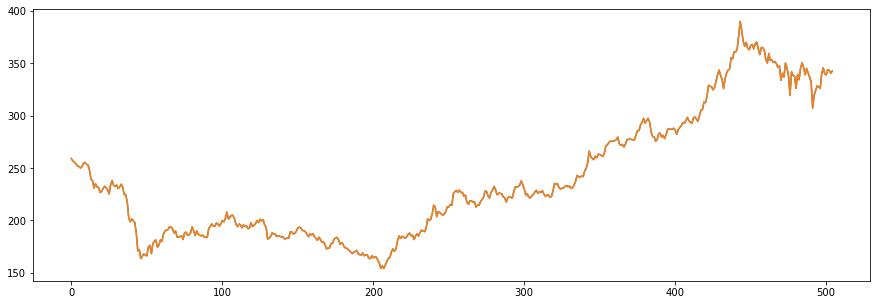

In [431]:
TrendFilteringADMM(r = 1, Lambda = 0, MaxIter = 1000)

100%|██████████| 1000/1000 [00:10<00:00, 96.35it/s]


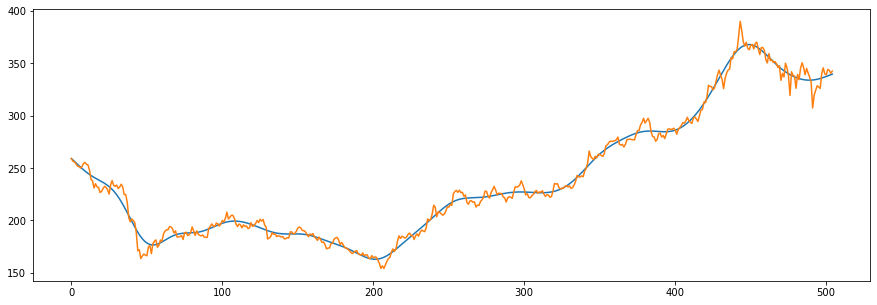

In [433]:
TrendFilteringADMM(r = 1, Lambda = 1e5, MaxIter = 1000)

100%|██████████| 1000/1000 [00:11<00:00, 90.56it/s]


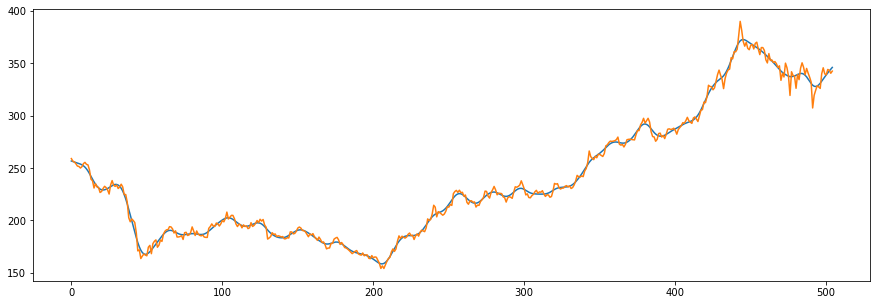

In [432]:
TrendFilteringADMM(r = 1e5, Lambda = 0, MaxIter = 1000)

100%|██████████| 1000/1000 [00:12<00:00, 80.42it/s]


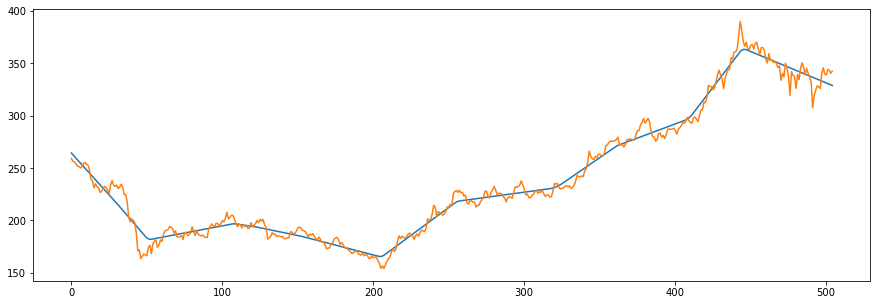

In [434]:
TrendFilteringADMM(r = 1e5, Lambda = 1000, MaxIter = 1000)

100%|██████████| 1000/1000 [00:13<00:00, 74.10it/s]


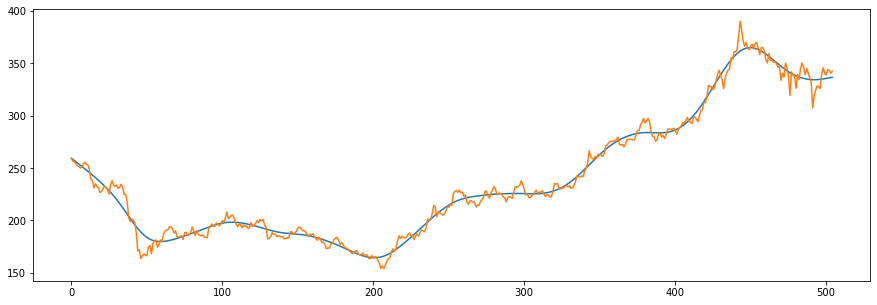

In [435]:
TrendFilteringADMM(r = 1e7, Lambda = 0, MaxIter = 1000)

100%|██████████| 1000/1000 [00:10<00:00, 93.92it/s]


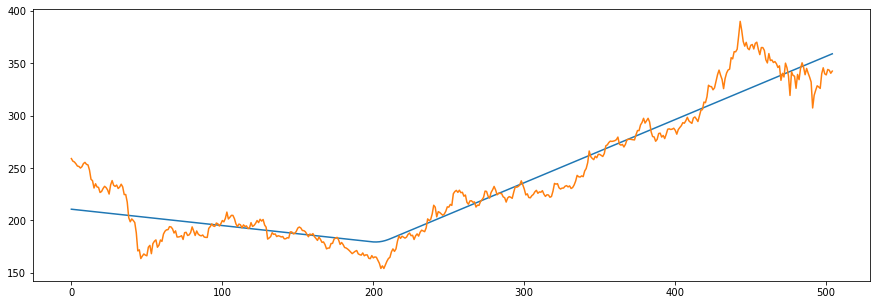

In [436]:
TrendFilteringADMM(r = 1e7, Lambda = 1e5, MaxIter = 1000)

# ADMM (13 pts)

Техника сглаживания оказала достаточно большое влияние на развитие методов восстановления тензоров (matrix completion problem является частным случаем). 

Рассмотрим задачу восстановления матрицы $Y$. Мы наблюдаем только небольшой набор элементов матрицы $Y$, множество индексов известных элементов обозначим через $E$. То есть мы знаем $Y_{ij}$ для всех $(i,j) \in E$, и не знаем $Y_{ij}$ для всех $(i,j) \notin E$.

Понятно, что без наличия какой-либо дополнительной информации о матрице $Y$ эта постановка является тривиальной: любая матрица $X$, для которой выполнено $X_{i,j} = Y_{i,j}, \quad (i,j) \in E$ является разумным ответом. Таких матриц бесконечно много. Соответственно задача восстановления матриц обычно рассматривается как частный случай задачи приближения матрицы, а критерий качества (целевая функция) говорит не столько о близости $X$ к $Y$, сколько о полезных свойствах матрицы $X$ (этим свойствам матрица $Y$ может и не обладать).

Одна из самых популярных постановок, с которой Вы наверняка сталкивались, например, строя рекомендательные системы, является задача о поиске наилучшего приближения заданной матрицы матрицей малого ранга:

$$
\begin{align*}
& \min_{X} rk(X) \\
& X_{i,j} = Y_{i,j}, \quad (i,j) \in E\\
\end{align*}
$$
Как известно, в общем случае эта задача является NP-трудной.

Для того, чтобы обойти это припятствие ранк матрицы аппроксимируется той или иной выпуклой функцией от матрицы $X$.

Опять же стандартным выбором является переход к постановке задачи с использованием 1-й нормы Шаттена (она же trace norm).

$\textbf{RegMC problem}$

$$
\begin{align*}
& \min_{X}\|X \|_* \\
& X_{i,j} = Y_{i,j}, \quad (i,j) \in E\\
\end{align*}
$$

Здесь $X_* = \sum \sigma_i(X)$. 


1. (1 pts) Сведите задачу RegMC к виду, пригодному для решения алгоритмом ADMM
2. (5 pts) Выпишите аналитическую запись всех шагов вычисления алгоритма ADMM для численного решения задачи, полученной в пункте 1.
3. (2 pts) Реализуйте метод ADMM. 
4. (5 pts) Протестируйте алгоритм из п.3 на тестовых данных. Сравните полученные результаты с результатами алгоритмов из ДЗ4.
От Вас требуется сравнить скорость сходимости методов на тестовых данных. Предложите метод сравнения и обоснуйте свой выбор.





### 1, 2) Сведем задачу RegMC к виду, пригодному для решения алгоритмом ADMM, и выпишем аналитическую запись всех шагов вычисления алгоритма ADMM для численного решения задачи, полученной в пункте 1.

- Введем усеченную 1-ю норму Шаттена:

    - Пусть дана матрица $X \in \mathbb{R}^{m \times n}$. Усеченной 1-й нормой Шаттена называется $|X|_r = \sum_{i = r + 1}^{min(n, m)}{\sigma_i(X)}$

- Будем решать следующую задачу:

$$
\begin{align*}
& \min_{X}\|X \|_r \\
& X_{i,j} = Y_{i,j}, \quad (i,j) \in E\\
\end{align*}
$$

- Поскольку $\|X \|_r$ не является выпуклой, то запишем задачу в другом виде, также пригодному для решения алгоритмом ADMM:

$$
\begin{align*}
& \min_{X}\|X \|_* - Tr(AWB^T)\\
& X = W,~~~ W_{i,j} = Y_{i,j}, \quad (i,j) \in E\\
\end{align*}
$$

где $A, B$ -  две унитарные матрицы, состоящие из левых и правых первых r сингулярных векторов соответственно. 

- Запишем модифицированную функцию Лагранжа:

$$
L(X, M, W, \rho) = \|X \|_* - Tr(AWB^T) + \frac{\rho}{2}\|X - W\|_F^2 + Tr(M^T(X - W)) 
$$

- Таким образом, k-ый шаг нашего алгоритма будет выглядеть следующим образом:

    $$
    X_{k + 1} = arg\min_{X}(L(X, M_k, W_k, \rho))
    $$
    
    $$
   X_{k + 1} = arg\min_{X}(\|X \|_* + \frac{\rho}{2}\|X - (W_k - \frac{1}{\rho}M^T)\|_F^2)
    $$
    
    $$
    [U_{k + 1}, \Sigma_{k + 1}, V_{k + 1}] = SVD(X_{k + 1}),
    $$
    
    $$
    U_{k + 1} = (u_1, ..., u_m) \in \mathbb{R}^{m \times m},~~~ V_{k + 1} = (v_1, ..., v_n) \in \mathbb{R}^{n \times n}
    $$
    
    $$
    A_{k + 1} = (u_1, ..., u_r) \in \mathbb{R}^{m \times r},~~~ B_{k + 1} = (v_1, ..., v_r) \in \mathbb{R}^{n \times r}
    $$
    
    $$
    W_{k + 1} = arg\min_{W}L(X_{k + 1}, M_k, W, \rho)
    $$
    
    $$
    W_{k + 1} = X_{k + 1} + \frac{1}{\rho}(A_{k + 1}^TB_{k + 1} + M_k)
    $$
    
    $$
    M_{k + 1} = M_{k} + \rho(X_{k + 1} - W_{k + 1})
    $$